In [0]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()


print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


2.2.0
Found GPU at: /device:GPU:0


In [0]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm
import tqdm

###  Data

In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 28
IMG_WIDTH = 28
NUM_CLASSES=10


In [0]:
class MNISTSequence(tf.keras.utils.Sequence):
  """Produces a sequence of MNIST digits with labels."""

  def __init__(self, data=None, batch_size=128, fake_data_size=None):
    """Initializes the sequence.
    Args:
      data: Tuple of numpy `array` instances, the first representing images and
            the second labels.
      batch_size: Integer, number of elements in each training batch.
      fake_data_size: Optional integer number of fake datapoints to generate.
    """
    if data:
      images, labels = data
    else:
      images, labels = MNISTSequence._generate_fake_data(
          num_images=fake_data_size, num_classes=NUM_CLASSES)
    self.images, self.labels = MNISTSequence.__preprocessing(
        images, labels)
    self.batch_size = batch_size

  def _generate_fake_data(self, num_images, num_classes):
    """Generates fake data in the shape of the MNIST dataset for unittest.
    Args:
      num_images: Integer, the number of fake images to be generated.
      num_classes: Integer, the number of classes to be generate.
    Returns:
      images: Numpy `array` representing the fake image data. The
              shape of the array will be (num_images, 28, 28).
      labels: Numpy `array` of integers, where each entry will be
              assigned a unique integer.
    """
    images = np.random.randint(low=0, high=256,
                               size=(num_images, IMG_HEIGHT,
                                     IMG_WIDTH))
    labels = np.zeros(num_images)+99
    #np.random.randint(low=0, high=num_classes,size=num_images)
    return images, labels

  @staticmethod
  def __preprocessing(images, labels):
    """Preprocesses image and labels data.
    Args:
      images: Numpy `array` representing the image data.
      labels: Numpy `array` representing the labels data (range 0-9).
    Returns:
      images: Numpy `array` representing the image data, normalized
              and expanded for convolutional network input.
      labels: Numpy `array` representing the labels data (range 0-9),
              as one-hot (categorical) values.
    """
    images = 2 * (images / 255.) - 1.
    images = images[..., tf.newaxis]

    labels = tf.keras.utils.to_categorical(labels)
    return images, labels

  def __len__(self):
    return int(tf.math.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, idx):
    batch_x = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
    return batch_x, batch_y

#### Data Generators

In [0]:
train_set, heldout_set = tf.keras.datasets.mnist.load_data()

train_data_gen = MNISTSequence(data=train_set, batch_size=batch_size)
val_data_gen = MNISTSequence(data=heldout_set, batch_size=batch_size)

In [0]:
len(train_data_gen)

469

In [0]:
train_data_gen[466][1].shape

(128, 10)

In [0]:

val_batches = int(heldout_set[0].shape[0] / batch_size)
train_batches = int(train_set[0].shape[0]  / batch_size)
train_batches

468

## Non bayesian

#### Setup

In [0]:
def make_model():

  model = tf.keras.models.Sequential([
                                      
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

      tf.keras.layers.Conv2D(
          6, kernel_size=5, padding='SAME',
          #kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tf.keras.layers.Conv2D(
          16, kernel_size=5, padding='SAME',
          #kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tf.keras.layers.Conv2D(
          120, kernel_size=5, padding='SAME',
          #kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          84, #kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax) #kernel_divergence_fn=kl_divergence_function,
          #activation=tf.nn.softmax)
  ])
  return model

In [0]:
class DummyHist(object):
  def __init__(self, hist):
    self.history=hist

def plot_hist(history, epochs=15):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(18, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [0]:
train_data_gen[0][0].shape

(128, 28, 28, 1)

In [0]:
tf.argmax(val_data_gen[0][1][0])

<tf.Tensor: shape=(), dtype=int64, numpy=7>

In [0]:
test_features = train_data_gen[0][0][0,:,:,:]

logit=model.predict(np.expand_dims(test_features, 0))
        #print(logit)
proba = tf.nn.softmax(logit).numpy()
        #print(proba)
prediction = tf.argmax(proba, axis=1).numpy()

In [0]:
prediction

array([5])

In [0]:
def generate_examples(model, N=5, batch_idxs=None, im_idxs=None):

    img_arr=[]
    lab_arr=[]
    pred_arr=[]
    probas=[]
    generate_idxs=False
    if batch_idxs is None:
      batch_idxs = []
      im_idxs = []
      generate_idxs = True
    for i in range(N):
        #print('i=%s'%i)
        if generate_idxs:
            #print('generating random indexes')
            batch_ind = np.random.randint(0, val_batches)
            im_ind = np.random.randint(0, batch_size) 
        else:
            #print('Using provided indexes')
            batch_ind = batch_idxs[i]
            im_ind = im_idxs[i]
        print(batch_ind, im_ind)

        test_features = val_data_gen[batch_ind][0][im_ind, :, :, :]
        #print('Features ok')
        test_label = tf.argmax(val_data_gen[batch_ind][1][im_ind])
        #print(test_label)
        logit=model.predict(np.expand_dims(test_features, 0))
        #print(logit)
        #proba = tf.nn.softmax(logit).numpy()
        proba=logit
        #print(proba)
        prediction = tf.argmax(logit,axis=1).numpy()
        #print(prediction)
        img_arr.append(test_features)
        lab_arr.append(test_label)
        pred_arr.append(prediction)
        probas.append(proba)
        #print('All appended')
        if generate_idxs:
            im_idxs.append(im_ind)
            batch_idxs.append(batch_ind)
            #print('Appending indexes')

    #print('Done')
    return np.array(img_arr), np.array(lab_arr), np.array(pred_arr), np.array(probas), np.array(batch_idxs), np.array(im_idxs)


In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_one_image(images_arr, lab, pred, probas):
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    img = images_arr.reshape((28, 28))
    ax.imshow(img,  cmap='gray')
    ax.axis('off')
    ax.set_title('True: %s , Predicted: %s \n'
                       %(str(lab), str(pred)
                         )+ '\n'.join([ 'p(%s)'%(j)+'='+str(probas[0][j]) for j in range(10)] ) )
    
    plt.tight_layout()
    plt.show()

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, lab_arr, pred_arr, probas):
    fig, axes = plt.subplots(1, images_arr.shape[0], figsize=(20,20))
    axes = axes.flatten()
    i=0
    for img, ax in zip( images_arr, axes):
        img = img.reshape((28, 28))
        ax.imshow(img,  cmap='gray')
        ax.axis('off')
        ax.set_title('True: %s , Predicted: %s \n'
                       %(str(lab_arr[i]), str(pred_arr[i])
                         )+ '\n'.join([ 'p(%s)'%(j)+'='+str(probas[i][0][j]) for j in range(10)] ) )
        i+=1
    plt.tight_layout()
    plt.show()

In [0]:
def save_model(fname, my_model):
  my_model.save(fname+'.h5')
  print("Saved model to disk")

def load_model(fname_load):
  model_loaded = tf.keras.models.load_model(fname_load+'.h5')
  print("Loaded model from disk")
  return model_loaded

#### Keras

###### Keras - training

In [0]:
model_k = make_model()

model_k.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model_k.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

In [0]:
history_k = model_k.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
15/15 [==============================] - 18s 1s/step - loss: 1.0024 - accuracy: 0.5128 - val_loss: 0.6964 - val_accuracy: 0.5156
Epoch 2/15
15/15 [==============================] - 18s 1s/step - loss: 0.6932 - accuracy: 0.5240 - val_loss: 0.6862 - val_accuracy: 0.5301
Epoch 3/15
15/15 [==============================] - 18s 1s/step - loss: 0.6855 - accuracy: 0.5454 - val_loss: 0.6803 - val_accuracy: 0.5759
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 0.6811 - accuracy: 0.5497 - val_loss: 0.6776 - val_accuracy: 0.5658
Epoch 5/15
15/15 [==============================] - 18s 1s/step - loss: 0.6752 - accuracy: 0.5828 - val_loss: 0.6675 - val_accuracy: 0.5949
Epoch 6/15
15/15 [==============================] - 18s 1s/step - loss: 0.6530 - accuracy: 0.6266 - val_loss: 0.6604 - val_accuracy: 0.6060
Epoch 7/15
15/15 [==============================] - 18s 1s/step - loss: 0.6466 - acc

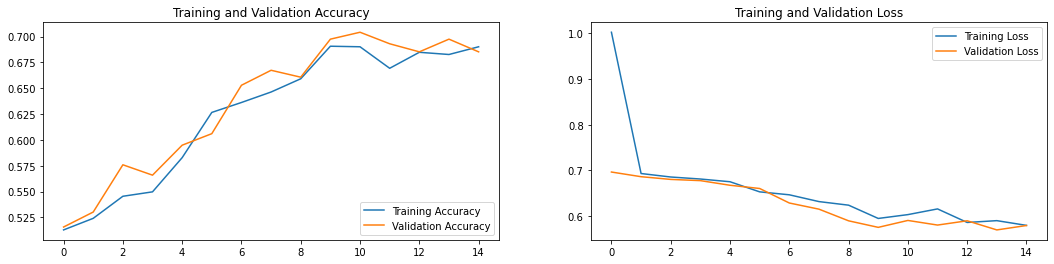

In [0]:
plot_hist(history_k, epochs=15)

In [0]:
fname = my_path+'cats_dogs_keras'

#save_model(fname, model_k)


###### keras - evaluation

In [0]:
fname = my_path+'cats_dogs_keras'

loaded_model_k = load_model(fname)
loaded_model_k.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Loaded model from disk


In [0]:
loaded_model_k.evaluate_generator(generator=val_data_gen, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
8/8 [==============================] - 2s 305ms/step - loss: 0.5520 - accuracy: 0.7150


[0.5520151257514954, 0.7149999737739563]

#### tf

###### tf train

In [0]:
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()


@tf.function
def train_on_batch(x, y, model, optimizer, loss):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)
        logits = model(x, training=True)
        loss_value = loss(y, logits)
        #loss_value += sum(model.losses)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    #proba = tf.nn.softmax(logits)
    prediction = tf.argmax(logits, axis=1)
    train_acc_metric.update_state(tf.argmax(y, axis=1), prediction)
    return loss_value

@tf.function
def val_step(x, y, model, loss):
    val_logits = model(x, training=False)
    val_loss_value = loss(y, val_logits)
    #proba = tf.nn.softmax(val_logits)
    prediction = tf.argmax(val_logits, axis=1)
    val_acc_metric.update_state(tf.argmax(y, axis=1), prediction)
    return val_loss_value


@tf.function
def my_loss(y, logits):
    loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True) #tf.nn.softmax_cross_entropy_with_logits(y, logits)
    return loss_f(y, logits) #tf.reduce_mean(loss_f(y, logits))



def my_train(model, optimizer, loss,
             epochs, 
             train_generator, 
             val_generator):
  #import time
  history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy':[] }
  
  

  try:
    epoch_bar = tqdm.notebook.trange(epochs, desc="Epochs")
    batch_bar = tqdm.notebook.trange(train_batches, desc="Train Batch")
    val_bar = tqdm.notebook.trange(val_batches, desc="Val Batch")
  except AttributeError:
    epoch_bar = tqdm.tnrange(epochs, desc="Epochs")
    batch_bar = tqdm.tnrange(train_batches, desc="Train Batch")
    val_bar = tqdm.tnrange(val_batches, desc="Val Batch")

  for epoch in epoch_bar:
    #print("\nStart of epoch %d" % (epoch,))
    #start_time = time.time()

    # Run train loop
    
    for batch_idx, batch in enumerate(batch_bar):
        x_batch_train, y_batch_train = train_generator[batch_idx]
        #y_batch_train = tf.convert_to_tensor(np.expand_dims(y_batch_train, axis=1), dtype='float32')
        loss_value = train_on_batch(x_batch_train, y_batch_train, model, optimizer, loss)
    
    train_acc = train_acc_metric.result()
    history['loss'].append(loss_value.numpy())
    history['accuracy'].append(train_acc.numpy())
    train_acc_metric.reset_states()
    #print(history)
    
    # Run  validation loop
    val_loss_value = 0.
    for batch_idx, batch in enumerate(val_bar):      
        x_batch_val, y_batch_val = val_generator[batch_idx]
        #y_batch_val = tf.convert_to_tensor(np.expand_dims(y_batch_val, axis=1), dtype='float32')
        lv = val_step(x_batch_val, y_batch_val, model, loss)/ float(val_batches)
        val_loss_value += lv
    
    val_acc = val_acc_metric.result()
    history['val_loss'].append(val_loss_value.numpy())
    history['val_accuracy'].append(val_acc.numpy())
    val_acc_metric.reset_states()
    
    epoch_bar.set_postfix(train_loss=loss_value.numpy(), val_loss=val_loss_value.numpy(), 
                          train_accuracy = train_acc.numpy(), val_accuracy=val_acc.numpy())
    #print("Time taken: %.2fs" % (time.time() - start_time))

   

  return model, history

In [297]:
# Prepare the inputs.


optimizer = tf.keras.optimizers.Adam()

model=make_model()

model.build(input_shape=(IMG_HEIGHT ,IMG_WIDTH , 1,))
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 7, 120)         48120     
_________________________________________________________________
flatten_23 (Flatten)         (None, 5880)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 84)              

In [298]:
model, history = my_train(model, optimizer, my_loss,
             epochs, 
            train_data_gen, 
             val_data_gen
)

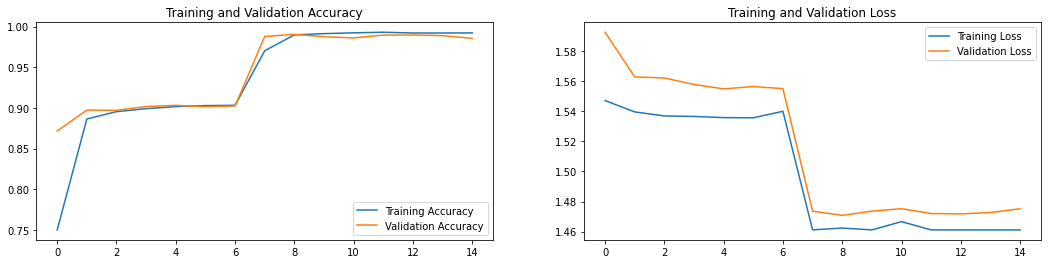

In [299]:
plot_hist(DummyHist(history), epochs=15)

In [0]:
fname_tf = my_path+'mnist_tf'
#save_model(fname_tf, model)

##### tf evaluation

In [322]:
#loaded_tf_model = load_model(my_path+'cats_dogs_tf')
val_data_gen[403][0].shape

(0, 28, 28, 1)

In [329]:
img_arr, lab_arr, pred_arr, probas, batch_idxs, im_idxs = generate_examples(model, N=5)

33 112
36 126
12 61
36 115
47 75


In [330]:
pred_arr.shape

(5, 1)

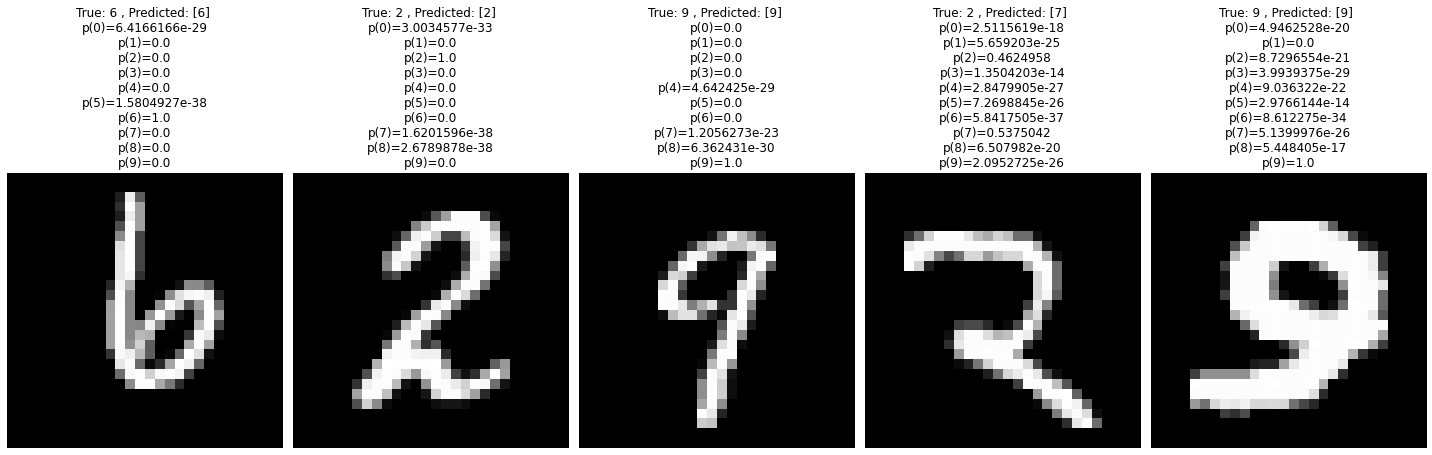

In [331]:
plotImages(img_arr, lab_arr, pred_arr, probas)

In [0]:
def make_fake_ex(model):
  fake_data_gen = MNISTSequence(data=train_set, batch_size=batch_size)
  fake_feat, fake_lab = fake_data_gen._generate_fake_data(1, 10)
  
  proba=model.predict(np.expand_dims(fake_feat, axis=-1))

  prediction = tf.argmax(proba,axis=1).numpy()

  plot_one_image(fake_feat, fake_lab, prediction, proba)

  return fake_feat, fake_lab, prediction, proba
    

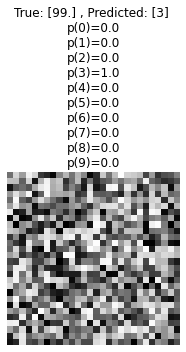

In [460]:
_ = make_fake_ex(model)

## Bayesian

* Bernoulli via dropout :  [this blogpost ](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) and https://arxiv.org/abs/1506.02142

* DropConnect: https://arxiv.org/abs/1906.04569

* Bayes by backprop :  https://arxiv.org/abs/1505.05424 
    + reparametrization trick : https://arxiv.org/abs/1312.6114
    + local reparametrization trick : https://arxiv.org/abs/1506.02557
        - for CNNs https://arxiv.org/abs/1806.05978
    + Flipout :  https://arxiv.org/abs/1803.04386

    + Normalizing flows: https://arxiv.org/abs/1802.04908

* [Aleatoric VS epistemic uncertainty]( https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556?via%3Dihub)


* Applications:

    + Bernoulli dropout, strong gravitational lenses:
    + comparison of methods + CMB

* Also check this implementation:  https://arxiv.org/abs/1812.03973


In [0]:
tfd = tfp.distributions

In [0]:
def make_model_bayes():

  # KL divergence weighted by the number of training samples, using
  # lambda function to pass as input to the kernel_divergence_fn on
  # flipout layers.
  kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(train_set[0].shape[0], dtype=tf.float32))

  model = tf.keras.models.Sequential([
                                      
    tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

      tfp.layers.Convolution2DFlipout(
          6, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          16, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          120, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseFlipout(
          84, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tfp.layers.DenseFlipout(
          10,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.softmax)
  ])
  
  return model
 

In [257]:
optimizer = tf.keras.optimizers.Adam()

model_bayes = make_model_bayes()

model_bayes.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_21 (Conv2DFli (None, 28, 28, 6)         306       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_flipout_22 (Conv2DFli (None, 14, 14, 16)        4816      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_flipout_23 (Conv2DFli (None, 7, 7, 120)         96120     
_________________________________________________________________
flatten_21 (Flatten)         (None, 5880)              0         
_________________________________________________________________
dense_flipout_14 (DenseFlipo (None, 84)              

In [0]:
@tf.function
def ELBO(y, logits, kl):
    loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False) #tf.nn.softmax_cross_entropy_with_logits(y, logits)
    neg_log_likelihood = loss_f(tf.squeeze(y), tf.squeeze(logits))#-tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))    
    #kl = sum(model.losses)
    loss = neg_log_likelihood + kl
    return tf.reduce_mean(loss)



In [259]:
x, y = train_data_gen[1]
y.shape

(128, 10)

In [260]:
logits=model_bayes(x)
logits.shape

TensorShape([128, 10])

In [0]:
proba = tf.squeeze(tf.nn.softmax(logits))
prediction = tf.squeeze(tf.argmax(proba, axis=1))
true = tf.argmax(y, axis=1)

In [262]:
proba[:3, :]

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[0.0900223 , 0.09010896, 0.09013455, 0.13125032, 0.10319143,
        0.10693084, 0.0898764 , 0.10017467, 0.08982031, 0.10849023],
       [0.08675904, 0.08675925, 0.08722437, 0.2080417 , 0.08885401,
        0.08957791, 0.09241378, 0.08685138, 0.08675904, 0.08675949],
       [0.08952507, 0.0894523 , 0.09316289, 0.10500183, 0.08985195,
        0.12189656, 0.09340715, 0.1386222 , 0.08944749, 0.0896325 ]],
      dtype=float32)>

In [0]:
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()


@tf.function
def train_on_batch(x, y, model, optimizer):
    y=tf.squeeze(y)
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)
        logits = model(x, training=True)
        kl = sum(model.losses)
        loss_value = ELBO(y, logits, kl)
        #print(loss_value)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    #proba = tf.squeeze(tf.nn.softmax(logits))
    prediction = tf.squeeze(tf.argmax(logits, axis=1))
    true = tf.argmax(y, axis=1)
    train_acc_metric.update_state(true, prediction)
    return loss_value

@tf.function
def val_step(x, y, model):
    y=tf.squeeze(y)
    val_logits = model(x, training=False)
    kl = sum(model.losses)
    val_loss_value = ELBO(y, val_logits, kl)
    #val_proba = tf.squeeze(tf.nn.softmax(val_logits))
    val_prediction = tf.squeeze(tf.argmax(logits, axis=1))
    val_true = tf.argmax(y, axis=1)
    val_acc_metric.update_state(val_true, val_prediction)
    return val_loss_value



def my_train_bayes(model, optimizer,
             epochs, 
             train_generator, 
             val_generator):
  #import time
  history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy':[] }
  
  

  try:
    epoch_bar = tqdm.notebook.trange(epochs, desc="Epochs")
    batch_bar = tqdm.notebook.trange(train_batches, desc="Train Batch")
    val_bar = tqdm.notebook.trange(val_batches, desc="Val Batch")
  except AttributeError:
    epoch_bar = tqdm.tnrange(epochs, desc="Epochs")
    batch_bar = tqdm.tnrange(train_batches, desc="Train Batch")
    val_bar = tqdm.tnrange(val_batches, desc="Val Batch")

  for epoch in epoch_bar:
    #print("\nStart of epoch %d" % (epoch,))
    #start_time = time.time()

    # Run train loop
    
    for batch_idx, batch in enumerate(batch_bar):
        x_batch_train, y_batch_train = train_generator[batch_idx]
        y_batch_train = tf.convert_to_tensor(np.expand_dims(y_batch_train, axis=1), dtype='float32')
        loss_value = train_on_batch(x_batch_train, y_batch_train, model, optimizer)
    
    train_acc = train_acc_metric.result()
    history['loss'].append(loss_value.numpy())
    history['accuracy'].append(train_acc.numpy())
    train_acc_metric.reset_states()
    #print(history)
    
    # Run  validation loop
    val_loss_value = 0.
    for batch_idx, batch in enumerate(val_bar):      
        x_batch_val, y_batch_val = val_generator[batch_idx]
        y_batch_val = tf.convert_to_tensor(np.expand_dims(y_batch_val, axis=1), dtype='float32')
        lv = val_step(x_batch_val, y_batch_val, model)/ float(val_batches)
        val_loss_value += lv
    
    val_acc = val_acc_metric.result()
    history['val_loss'].append(val_loss_value.numpy())
    history['val_accuracy'].append(val_acc.numpy())
    val_acc_metric.reset_states()
    
    epoch_bar.set_postfix(train_loss=loss_value.numpy(), val_loss=val_loss_value.numpy(), 
                          train_accuracy = train_acc.numpy(), val_accuracy=val_acc.numpy())
    #print("Time taken: %.2fs" % (time.time() - start_time))

   

  return model, history

In [264]:
model_bayes, history_bayes = my_train_bayes(model=model_bayes, optimizer=optimizer,
             epochs=epochs, 
             train_generator=train_data_gen, 
             val_generator=val_data_gen
)

Tensor("Squeeze_1:0", shape=(128,), dtype=int64)
Tensor("ArgMax_1:0", shape=(128,), dtype=int64)
Tensor("Squeeze_1:0", shape=(128,), dtype=int64)
Tensor("ArgMax_1:0", shape=(128,), dtype=int64)





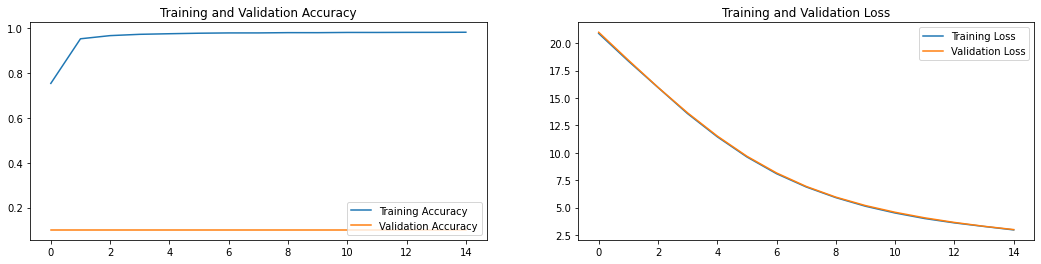

In [265]:
plot_hist(DummyHist(history_bayes), epochs=15)


In [0]:
#save_model(my_path+'catsdogs_bayes', model_bayes)

##### Keras example

In [0]:
def keras_training(model, train_seq, heldout_seq):
  for epoch in range(15):
    epoch_accuracy, epoch_loss = [], []
    for step, (batch_x, batch_y) in enumerate(train_seq):
      batch_loss, batch_accuracy = model.train_on_batch(
          batch_x, batch_y)
      epoch_accuracy.append(batch_accuracy)
      epoch_loss.append(batch_loss)

      if step % 100 == 0:
        print('Epoch: {}, Batch index: {}, '
              'Loss: {:.3f}, Accuracy: {:.3f}'.format(
                  epoch, step,
                  tf.reduce_mean(epoch_loss),
                  tf.reduce_mean(epoch_accuracy)))

      if (step+1) % 400 == 0:
        # Compute log prob of heldout set by averaging draws from the model:
        # p(heldout | train) = int_model p(heldout|model) p(model|train)
        #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
        # where model_i is a draw from the posterior p(model|train).
        print(' ... Running monte carlo inference')
        probs = tf.stack([model.predict(heldout_seq, verbose=0)
                          for _ in range(100)], axis=0)
        mean_probs = tf.reduce_mean(probs, axis=0)
        heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
        print(' ... Held-out nats: {:.3f}'.format(heldout_log_prob))


  return model, epoch_accuracy, epoch_loss

In [267]:
optimizer = tf.keras.optimizers.Adam()

model_bayes_k = make_model_bayes()
model_bayes_k.compile(optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'], experimental_run_tf_function=False)

model_bayes_k.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_24 (Conv2DFli (None, 28, 28, 6)         306       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_flipout_25 (Conv2DFli (None, 14, 14, 16)        4816      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_flipout_26 (Conv2DFli (None, 7, 7, 120)         96120     
_________________________________________________________________
flatten_22 (Flatten)         (None, 5880)              0         
_________________________________________________________________
dense_flipout_16 (DenseFlipo (None, 84)              

In [268]:
%%time
model_k, epoch_accuracy_k, epoch_loss_k = keras_training(model_bayes_k, train_data_gen, val_data_gen)

Epoch: 0, Batch index: 0, Loss: 27.561, Accuracy: 0.109
Epoch: 0, Batch index: 100, Loss: 24.391, Accuracy: 0.469
Epoch: 0, Batch index: 200, Loss: 23.657, Accuracy: 0.647
Epoch: 0, Batch index: 300, Loss: 23.190, Accuracy: 0.730
 ... Running monte carlo inference
 ... Held-out nats: -7.887
Epoch: 0, Batch index: 400, Loss: 22.818, Accuracy: 0.778
Epoch: 1, Batch index: 0, Loss: 21.002, Accuracy: 0.953
Epoch: 1, Batch index: 100, Loss: 20.782, Accuracy: 0.946
Epoch: 1, Batch index: 200, Loss: 20.513, Accuracy: 0.950
Epoch: 1, Batch index: 300, Loss: 20.251, Accuracy: 0.952
 ... Running monte carlo inference
 ... Held-out nats: -9.319
Epoch: 1, Batch index: 400, Loss: 19.990, Accuracy: 0.954
Epoch: 2, Batch index: 0, Loss: 18.549, Accuracy: 0.969
Epoch: 2, Batch index: 100, Loss: 18.327, Accuracy: 0.963
Epoch: 2, Batch index: 200, Loss: 18.059, Accuracy: 0.966
Epoch: 2, Batch index: 300, Loss: 17.799, Accuracy: 0.966
 ... Running monte carlo inference
 ... Held-out nats: -10.169
Epoch: 

#### Predictions

33 112
36 126
12 61
36 115
47 75


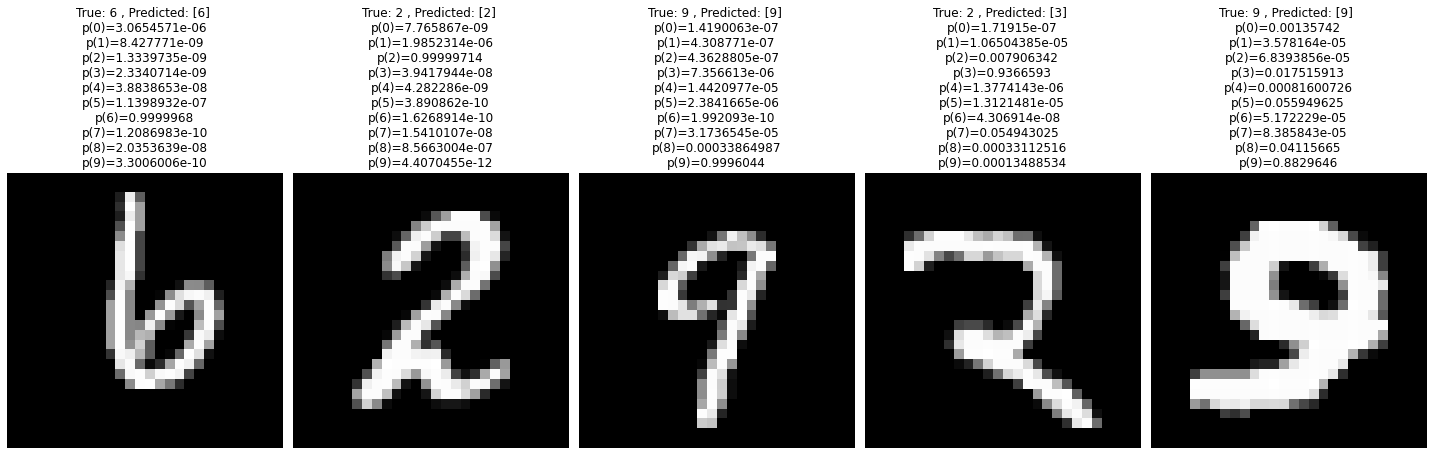

In [447]:
aimg_arr, lab_arr, pred_arr, probas, batch_idxs, im_idxs = generate_examples(model_bayes, N=5, batch_idxs=batch_idxs, im_idxs=im_idxs)

plotImages(img_arr, lab_arr, pred_arr, probas)

In [0]:
num_monte_carlo= 500

# sampling
sampled_probas = tf.stack([model_bayes.predict(img_arr, verbose=0)
                          for _ in range(num_monte_carlo)], axis=0)

# one shot prediction
best_proba = tf.reduce_mean(sampled_probas, axis=0)
sampled_predictions = tf.argmax(best_proba, axis=1) 

In [450]:
sampled_probas.shape

TensorShape([500, 5, 10])

In [451]:
best_proba[3, 2]

<tf.Tensor: shape=(), dtype=float32, numpy=0.81914866>

In [452]:
best_proba[3, 7]

<tf.Tensor: shape=(), dtype=float32, numpy=0.13346097>

In [453]:
median = tfp.stats.percentile(sampled_probas, 50, axis=0)
median[3, 2]

<tf.Tensor: shape=(), dtype=float32, numpy=0.96968013>

In [0]:
def plot_dist(k, sampled_probas):
  median = tfp.stats.percentile(sampled_probas, 50, axis=0)
  fig, axs = plt.subplots(1, 10, sharey=True,figsize=(25,3))
  for j in range(10):
      histo = sampled_probas[:,k,j]
      N, bins, patches = axs[j].hist(histo, bins=10, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
      axs[j].set_title(str(j)+" (median="+str(round(median[k, j].numpy(),5))+")") 
  plt.show()

One-shot labeling:


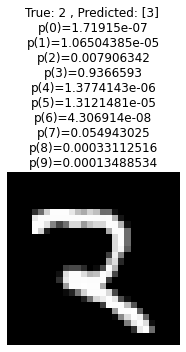


 Distribution:


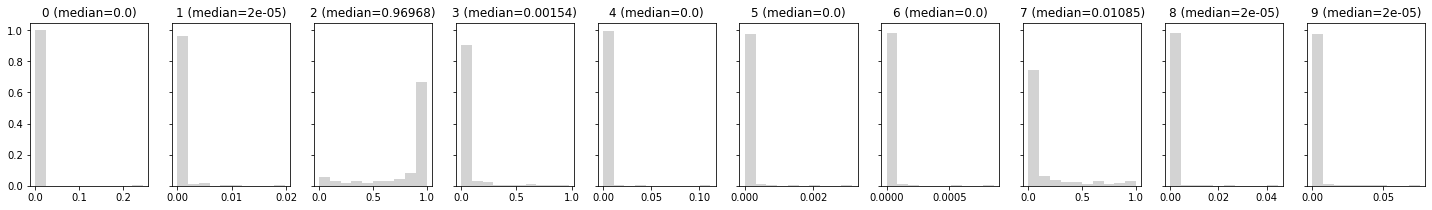

In [563]:
k=3
print('One-shot labeling:')
plot_one_image(img_arr[k, :,:,:], lab_arr[k], pred_arr[k], probas[k,:,:])

print('\n Distribution:')
plot_dist(k, sampled_probas)

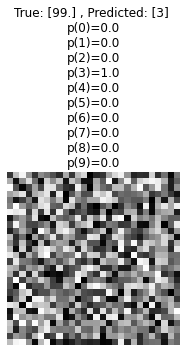

In [564]:
fake_feat, fake_lab, prediction, proba = make_fake_ex(model_bayes)

In [0]:
# sampling
sampled_probas_fake = tf.stack([model_bayes.predict(np.expand_dims(fake_feat, axis=-1), verbose=0)
                          for _ in range(num_monte_carlo)], axis=0)



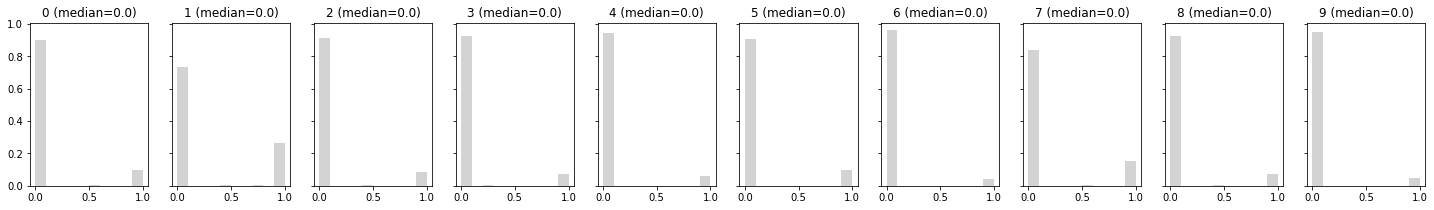

In [566]:
plot_dist(0, sampled_probas_fake)

In [0]:
def plot_one_image_bayes(images_arr, lab,  sampled_probas, th_prob=0.2):
    
    #sampled_probas = tf.squeeze(sampled_probas)
    median = tfp.stats.percentile(sampled_probas, 50, axis=0)
    if median[median>th_prob].numpy().sum()==0.:
      pred_label = 'Not predictable'
    else:
      pred_label = tf.argmax(median, axis=1).numpy()
    median_p = tf.reduce_max(median, axis=1)
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    img = images_arr.reshape((28, 28))
    ax.imshow(img,  cmap='gray')
    ax.axis('off')
    ax.set_title('True: %s , Predicted: %s \n'
                       %(str(lab), str(pred_label)
                         )+ '\n'.join([ 'p(%s)'%(j)+'='+str(median[0,j].numpy()) for j in range(10)] ) )
    
    plt.tight_layout()
    plt.show()

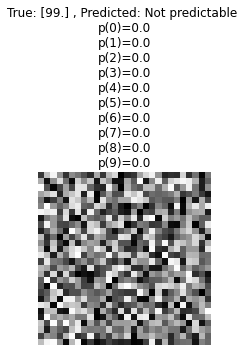

In [568]:
plot_one_image_bayes(fake_feat, fake_lab, sampled_probas_fake)

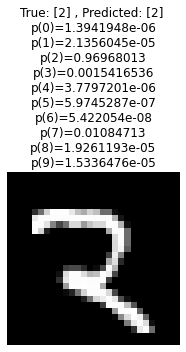

In [569]:
plot_one_image_bayes(img_arr[k, :,:,:], np.array([lab_arr[k],]), np.expand_dims(sampled_probas[:,k,:], axis=1))